In [1]:
import numpy as np
import scipy
import math
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import math

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
R1 = np.array([ [1, 0, 0], [0, 1, 0], [0, 0, 1]])
R2 = np.array([ [1, 0, 0], [0, 1, 0], [0, 0, 1]])
t1 = np.array([ [0], [0], [1]])
t2 = np.array( [[0], [0], [20]])
K = np.array([ [700, 0, 600], [0, 700, 400], [0, 0, 1]])
Q = np.array([ [1], [1], [0]]) 

# Ex 5.1

In [3]:
P1 = K @ np.hstack((R1, t1))
P2 = K @ np.hstack((R2, t2))
print('P1:{}\nP2:{}'.format(P1, P2))

q1 = P1 @ np.vstack((Q, 1))
q2 = P2 @ np.vstack((Q, 1))
q1 = q1[:-1]/q1[-1]
q2 = q2[:-1]/q2[-1]
print('q1:{}\nq2:{}'.format(q1, q2))

P1:[[700   0 600 600]
 [  0 700 400 400]
 [  0   0   1   1]]
P2:[[  700     0   600 12000]
 [    0   700   400  8000]
 [    0     0     1    20]]
q1:[[1300.]
 [1100.]]
q2:[[635.]
 [435.]]


# Ex 5.2

In [4]:
def triangulate(q, P):
    B = []
    for i, p in zip(q,P):
        a1 = p[2][0] * i[0] - p[0][0] 
        a2 = p[2][1] * i[0] - p[0][1]
        a3 = p[2][2] * i[0] - p[0][2]
        a4 = p[2][3] * i[0] - p[0][3]
        a = (a1, a2, a3, a4)
        B.append(a)
        b1 = p[2][0] * i[1] - p[1][0] 
        b2 = p[2][1] * i[1] - p[1][1]
        b3 = p[2][2] * i[1] - p[1][2]
        b4 = p[2][3] * i[1] - p[1][3]
        b = (b1, b2, b3, b4)
        B.append(b)
    B = np.array(B).reshape(-1,4)
    U, S, V = np.linalg.svd(B)
    B = V[-1, :]
    return B

In [5]:
q1_noise = q1 + np.array([ [1], [-1]])
q2_noise = q2 + np.array([ [1], [-1]])

q = [q1_noise, q2_noise]
P = [P1, P2]
B = triangulate(q,P)
Q_noise = (B[:-1]/B[-1]).reshape(3, -1)
error_Q = (np.linalg.norm(Q_noise-Q)) ** 2
print('Q_noise:\n{}\nerror_Q:\n{}'.format(Q_noise, error_Q))

Q_noise:
[[1.01527507e+00]
 [9.85270570e-01]
 [2.85786810e-04]]
error_Q:
0.00045036553178026554


In [6]:
q1_reproj = P1 @ np.vstack((Q_noise, 1))
q2_reproj = P2 @ np.vstack((Q_noise, 1))
q1_reproj = (q1_reproj[:-1]/q1_reproj[-1]).reshape(2, 1)
q2_reproj = (q2_reproj[:-1]/q2_reproj[-1]).reshape(2, 1)
error_cam1 = (np.linalg.norm(q1_reproj-q1)) ** 2
error_cam2 = (np.linalg.norm(q2_reproj-q2)) ** 2
print('q1_reproj:\n{}\nerror_q1:\n{}\nq2_reproj:\n{}\nerror_q2:\n{}'.format(q1_reproj, error_cam1, q2_reproj, error_cam2))

q1_reproj:
[[1310.48950027]
 [1089.4923513 ]]
error_q1:
220.4402970729299
q2_reproj:
[[635.53411968]
 [434.4839772 ]]
error_q2:
0.5515633606023123


In [7]:
q1_reproj-q1

array([[ 10.48950027],
       [-10.5076487 ]])


# Ex 5.3 & 5.4

In [11]:
def triangulate_nolin(q, P):
    def compute_residuals(Q):
        residuals = []
        for i,j in zip(q,P):
            proj = j @ (np.hstack((Q,1))).T
            proj = (proj[:-1]/proj[-1]).reshape(2,1)
            dist = proj- i
            residuals.append(dist)
        return np.array(residuals).reshape(-1) ## input of func in least_squares must be 1-d
    
    x0 = triangulate(q, P)
    x0 = x0[:-1]/x0[-1]
    res = least_squares(compute_residuals, x0) ## from scipy.optimize import least_squares
    return res

In [12]:
q = [q1_noise, q2_noise]
P = [P1, P2]
res = triangulate_nolin(q, P)
Q_hat = res.x  ## least_squares results is stored in res.x
print('Triangulae points:\n{}\nOriginal points:\n{}'.format(Q_hat, Q.reshape(-1)))
error_Q = np.linalg.norm((Q_hat-Q.reshape(-1))) ** 2
print('error_Q:\n',error_Q)

Triangulae points:
[1.00153897e+00 9.98546322e-01 4.27496202e-05]
Original points:
[1 1 0]
error_Q:
 4.483447712135183e-06


In [13]:
## reprojection error to cam1 and cam2
rep_cam1 = P1 @ np.hstack((Q_hat, 1))
rep_cam1 = (rep_cam1[:-1]/rep_cam1[-1]).reshape(-1,1)
rep_cam2 = P2 @ np.hstack((Q_hat, 1))
rep_cam2 = (rep_cam2[:-1]/rep_cam2[-1]).reshape(-1,1)
rep_error_cam1 = (np.linalg.norm((rep_cam1-q1))) ** 2
rep_error_cam2 = (np.linalg.norm((rep_cam2-q2))) ** 2
print('q1_reproj:\n{}\nrep_error_cam1:\n{}\nq2_reproj:\n{}\nrep_error_cam2:\n{}'.format(rep_cam1, rep_error_cam1, rep_cam2, rep_error_cam2))

q1_reproj:
[[1301.04731246]
 [1098.95254574]]
rep_error_cam1:
2.194023805289918
q2_reproj:
[[635.05378917]
 [434.94904658]]
rep_error_cam2:
0.005489525765167147


The error from non-linear is 10 timers smaller than that from linear method

# Camera Calibration with OpenCV

## Ex 5.6 & Ex 5.7

In [11]:
import os
import cv2
import numpy as np

In [12]:
class CalibrateCamera():
    def CrossOp(self, p):
        CP_matrix = np.array([ [0, -p[2], p[1]], [p[2], 0, -p[0]], [-p[1], p[0], 0]], dtype = 'float32')
        return CP_matrix
    
    def normalize2d(self, p):
        '''
        Normalize = (x-mean)/std
        '''
        X = p[:,0]
        Y = p[:,1]
        T = np.array([ [1/X.std(), 0, -X.mean()/X.std()], [0, 1/Y.std(), -Y.mean()/Y.std()], [0, 0, 1] ])
        q = T @ p.T
        return T, q.T

    def estimateHomographies(self, Q_omega, qs):
        ### qs is Homogenous coordinates with shape(3,-1)
        H = []
        for i in qs:
            Q = np.vstack((Q_omega[0:2], np.ones((1, Q_omega.shape[1]))))
            q = np.vstack((i, np.ones((1, i.shape[1]))))
            T_Q, Q_norm = self.normalize2d(Q.T)
            T_q, q_norm = self.normalize2d(q.T)
            B = []
            B.append([np.kron(a.T, self.CrossOp(b)) for a,b in zip(Q_norm, q_norm)])
            B = np.array(B).reshape(-1,9)
            U, S, V = np.linalg.svd(B)
            h = V[-1,:].reshape(-1,3).T
            h = np.linalg.inv(T_q) @ h @ T_Q 
            H.append(h)
        H = np.array(H)
        return H
    
    
    '''
    def Vtemp(self, H):
        v12 = np.array([H[0,0]*H[0,1],H[0,0]*H[1,1]+H[1,0]*H[0,1],H[1,0]*H[1,1],
                       H[2,0]*H[0,1]+H[0,0]*H[2,1],H[2,0]*H[1,1]+H[1,0]*H[2,1],H[2,0]*H[2,1]])
        v11 = np.array([H[0,0]*H[0,0],H[0,0]*H[1,0]+H[1,0]*H[0,0],H[1,0]*H[1,0],
                       H[2,0]*H[0,0]+H[0,0]*H[2,0],H[2,0]*H[1,0]+H[1,0]*H[2,0],H[2,0]*H[2,0]])
        v22 = np.array([H[0,1]*H[0,1],H[0,1]*H[1,1]+H[1,1]*H[0,1],H[1,1]*H[1,1],
                       H[2,1]*H[0,1]+H[0,1]*H[2,1],H[2,1]*H[1,1]+H[1,1]*H[2,1],H[2,1]*H[2,1]])
        Vtemp = np.vstack([v12,v11-v22])    
        return Vtemp

    def formV(self, Hs):
        V = self.Vtemp(Hs[0])
        for k in range(1,len(Hs)):
            vtemp = self.Vtemp(Hs[k])
            V=np.vstack((V,vtemp))
        return V

    def estimate_b(self,Hs):
        V = self.formV(Hs)
        _,_,Vt = np.linalg.svd(V)
        b = Vt[-1]    
        return b

    
    
    '''
    def v_vector(self, H, i,j):
        i = i-1
        j = j-1
        v = np.array([H[0][i]*H[0][j], H[0][i]*H[1][j] + H[1][i]*H[0][j], H[1][i]*H[1][j], H[2][i]*H[0][j] + H[0][i]*H[2][j], H[2][i]*H[1][j] + H[1][i]*H[2][j], H[2][i]*H[2][j]])
        return v

    def estimate_b(self, Hs):
        V = []
        for H in Hs:
            v12 = self.v_vector(H, 1, 2)
            V.append(v12)
            v11 = self.v_vector(H, 1, 1)
            v22 = self.v_vector(H, 2, 2)
            V.append((v11-v22))
        V = np.array(V).reshape(-1, 6)
        U, S, D = np.linalg.svd(V)
        b = D[-1,:]
        return b
    
    def estimateIntrinsics(self, Hs):
        b = self.estimate_b(Hs)
        v0 = (b[1]*b[3] - b[0]*b[4])/(b[0]*b[2] - b[1]**2)
        Lambda = b[5] - ((b[3]**2 + v0*(b[1]*b[3] - b[0]*b[4]))/b[0])
        alpha = np.sqrt(Lambda/b[0])
        Value = (Lambda*b[0])/(b[0]*b[2] - (b[1]**2))
        print(Value)
        print(b[0])
        print(Lambda)
        beta = np.sqrt(Value)
        gamma = -b[1]*(alpha**2)*beta/Lambda
        u0 = gamma*v0/beta - (b[3]*(alpha**2)/Lambda)
        proj_matrix = np.array([ [alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])
        return proj_matrix
    
    def estimateExtrinsics(self, K, Hs):
        R = []
        T = []
        for h in Hs:
            Lambda = 1/np.linalg.norm(np.linalg.inv(K)@h[:,0])
            t = Lambda * np.linalg.inv(K) @ h[:,2]

            if t[2] < 0:
                h = -h
                Lambda = 1/np.linalg.norm(np.linalg.inv(K)@h[:,0])
                t = Lambda * np.linalg.inv(K) @ h[:,2]
                
            r1 = Lambda * np.linalg.inv(K) @ h[:,0]
            r2 = Lambda * np.linalg.inv(K) @ h[:,1]
            r3 = np.cross(r1, r2)
            R.append(np.vstack((r1, r2, r3)).T)
            T.append(t)
        R = np.array(R)
        T = np.array(T)
        return R, T
    
    def calibrate(self, qs, Q):
        '''
        qs and Q are all Non-Homogenous coornidates 
        with the shape of (3,N)
        '''
        H = self.estimateHomographies(Q, qs)
        K = self.estimateIntrinsics(H)
        R, T = self.estimateExtrinsics(K, H)
        return K, R, T

In [13]:
images = []
for i in range(20):  
    path = "photo/pic(%d).jpg"%(i+1)
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) ##the default color channel in openCV is BGR
    img = cv2.resize(img,(400,600))
    images.append(img)

error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [14]:
#checkboard
cornerpoints =[]
plt.figure(figsize=(20,25)) 
for i in range(20):
    retval, corners = cv2.findChessboardCorners(images[i],(10,7))
    if retval ==True:
        cornerpoints.append(corners.astype('float32'))
        paint = cv2.drawChessboardCorners(images[i],(10,7),corners,retval)
        plt.subplot(4,5,i+1)
        plt.imshow(paint)
      

IndexError: list index out of range

<Figure size 1440x1800 with 0 Axes>

In [96]:
qs = [] ##Detected Points
for i in range(len(cornerpoints)):    
    r, _, c = cornerpoints[i].shape
    q_ = np.zeros(shape=(c, r))
    q_[0, :] = cornerpoints[i][:,0,0]
    q_[1, :] = cornerpoints[i][:,0,1]
    qs.append(q_)

In [97]:
Q = checkerboard_points(7, 10).astype('float32')
Camera_Calibrate = CalibrateCamera()
K, R, T = Camera_Calibrate.calibrate(qs, Q)

229835.58991918416
3.412187167927224e-06
0.620262802327717


In [98]:
K

array([[4.26355084e+02, 2.27392177e-01, 2.00554079e+02],
       [0.00000000e+00, 4.79411712e+02, 2.99877266e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [15]:
path = './SelfCheckBoard/png/'
for f in os.listdir(path):
    if f.endswith('.jpg'):
        img = cv2.imread(os.path.join(path,f))
        img = cv2.resize(img, (400, 600))
        gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
        ret, corners = cv2.findChessboardCorners(gray, (10, 7)) 
        if ret == False:
            print(f)
            os.remove(os.path.join(path, f))

FileNotFoundError: [Errno 2] No such file or directory: './SelfCheckBoard/png/'

In [19]:
def checkerboard_points(n,m):  ## n: horizontal, m: vertical
    Q = []
    for i in range(n):
        for j in range(m):
            Q.append([i - (n-1)/2, j - (m-1)/2, 0])
    Q = np.array(Q, dtype = np.float32).T.reshape(3,-1)
    return Q

In [20]:
path = './SelfCheckBoard/png2/'

framelist = []
Q = checkerboard_points(10,7)
count = 1
for f in os.listdir(path):
    if f.endswith('.jpg'):
        framelist.append(f)
framelist.sort()

Corners = []
qs = []
for i in framelist[:20]:
    img = cv2.imread(os.path.join(path,f))
    img = cv2.resize(img, (400, 600))
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (10, 7)) 
    if ret == True:
        Corners.append(corners)
for i in range(len(Corners)):    
    r, _, c = Corners[i].shape
    q = np.zeros((c, r))
    q[0, :] = Corners[i][:,0,0]
    q[1, :] = Corners[i][:,0,1]
    qs.append(q)
    

In [52]:
qs

[array([[312.62484741, 312.51345825, 312.53430176, 312.46514893,
         311.49987793, 311.79598999, 311.81506348, 311.51397705,
         311.51907349, 311.52133179, 286.54034424, 286.54714966,
         286.55755615, 286.01428223, 285.5461731 , 285.54171753,
         285.5647583 , 285.76361084, 286.39910889, 286.46694946,
         258.49517822, 258.51846313, 258.47171021, 258.49926758,
         258.49209595, 258.51626587, 258.50076294, 259.11419678,
         259.53884888, 259.49856567, 229.51123047, 229.52172852,
         229.50378418, 229.48590088, 229.51425171, 230.5088501 ,
         230.47854614, 230.48773193, 231.48251343, 231.51708984,
         198.19795227, 198.4574585 , 198.55534363, 199.489151  ,
         199.48786926, 200.5594635 , 200.48397827, 200.50041199,
         201.55473328, 201.4694519 , 164.68435669, 165.49247742,
         166.51109314, 167.1341095 , 167.47036743, 168.49023438,
         169.35247803, 169.54367065, 169.51519775, 170.17570496,
         129.61639404, 13

In [34]:
Corners

[array([[312.62485 , 312.51346 , 312.5343  , 312.46515 , 311.49988 ,
         311.796   , 311.81506 , 311.51398 , 311.51907 , 311.52133 ,
         286.54034 , 286.54715 , 286.55756 , 286.01428 , 285.54617 ,
         285.54172 , 285.56476 , 285.7636  , 286.3991  , 286.46695 ,
         258.49518 , 258.51846 , 258.4717  , 258.49927 , 258.4921  ,
         258.51627 , 258.50076 , 259.1142  , 259.53885 , 259.49857 ,
         229.51123 , 229.52173 , 229.50378 , 229.4859  , 229.51425 ,
         230.50885 , 230.47855 , 230.48773 , 231.48251 , 231.51709 ,
         198.19795 , 198.45746 , 198.55534 , 199.48915 , 199.48787 ,
         200.55946 , 200.48398 , 200.50041 , 201.55473 , 201.46945 ,
         164.68436 , 165.49248 , 166.5111  , 167.13411 , 167.47037 ,
         168.49023 , 169.35248 , 169.54367 , 169.5152  , 170.1757  ,
         129.6164  , 130.49257 , 131.56004 , 132.49179 , 133.50383 ,
         134.48433 , 135.5299  , 135.51047 , 136.51585 , 136.53357 ],
        [126.423775, 161.40198 , 

In [21]:
Q = checkerboard_points(10, 7)
Camera_Calibrate = CalibrateCamera()
K, R, T = Camera_Calibrate.calibrate(qs, Q)

nan
0.0
nan


<ipython-input-12-b970940867c2>:83: RuntimeWarning: invalid value encountered in double_scalars
  v0 = (b[1]*b[3] - b[0]*b[4])/(b[0]*b[2] - b[1]**2)


In [22]:
K

array([[nan, nan, nan],
       [ 0., nan, nan],
       [ 0.,  0.,  1.]])

## Self checkboard

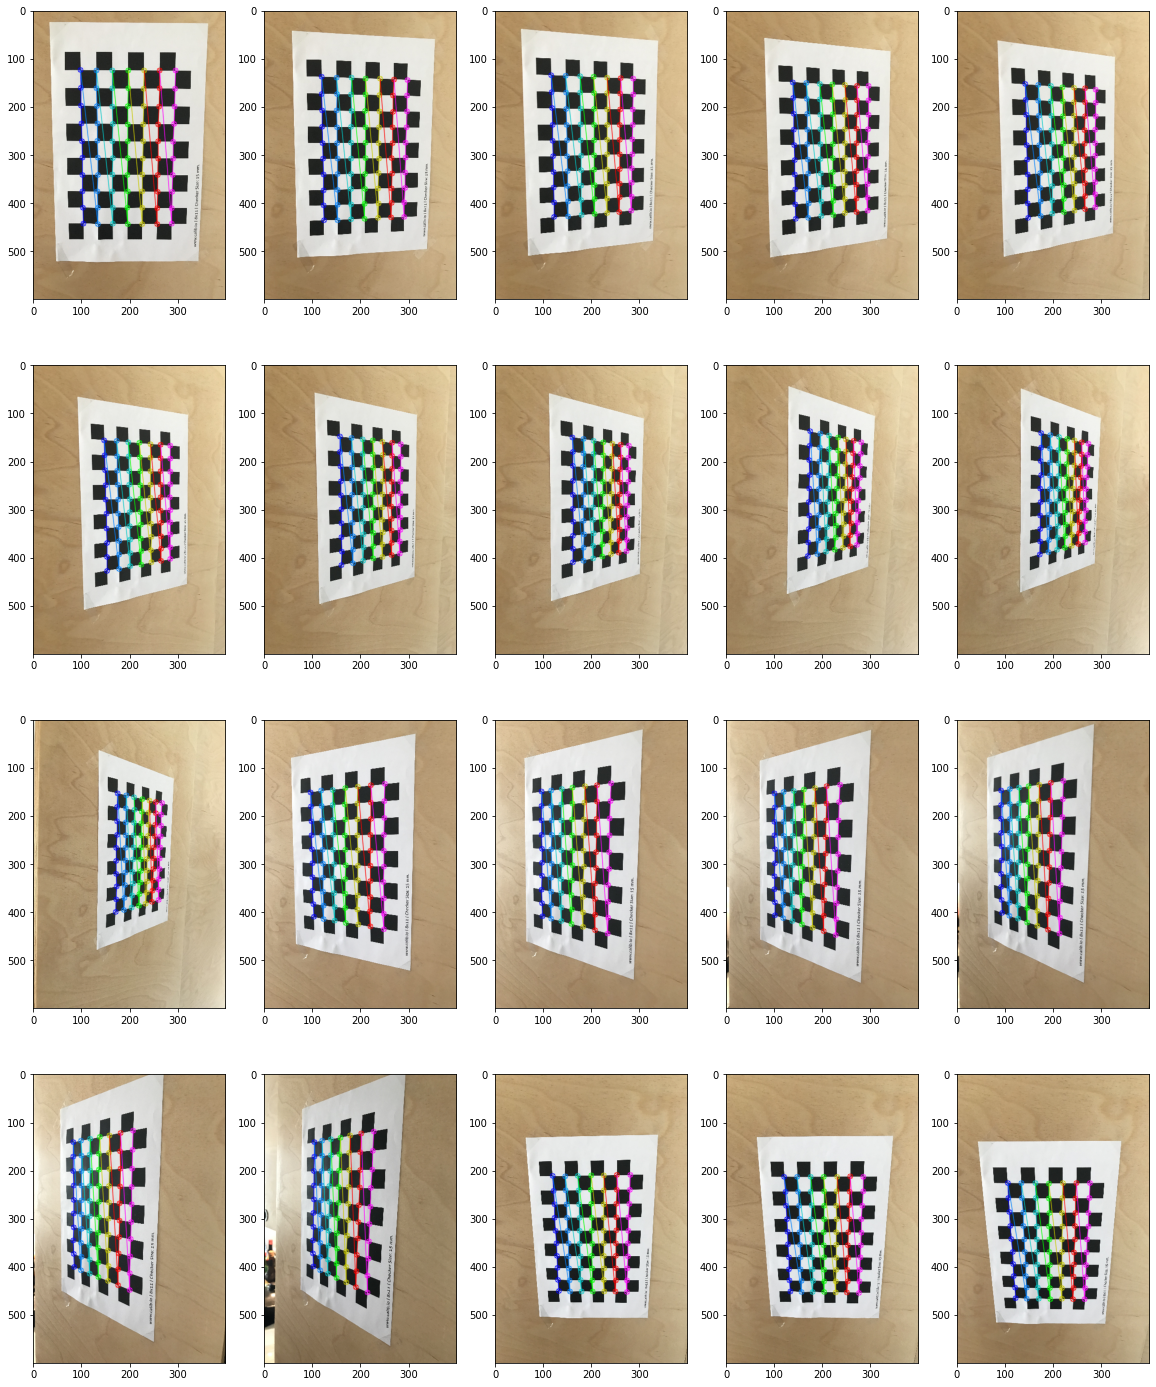

In [122]:
#Load the images
import os
path = './SelfCheckBoard/png/'
images = []


framelist = []
count = 1
for f in os.listdir(path):
    if f.endswith('.png'):
        framelist.append(f)
framelist.sort()
for f in framelist:
    img = cv2.imread(os.path.join(path,f))
    img = cv2.resize(img, (400, 600))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    images.append(img)
    

cornerpoints =[]
plt.figure(figsize=(20,25)) 
for i in range(20):
    ret, corners = cv2.findChessboardCorners(images[i],(10,7))
    if ret ==True and i <=19:
        cornerpoints.append(corners)
        img = cv2.drawChessboardCorners(images[i],(10,7),corners,ret)
        plt.subplot(4,5,i+1)
        plt.imshow(img)
      

In [123]:
def normalize2D(pi):
    #pih = np.vstack((pi, np.ones(len(pi[0]))))
    m = np.mean(pi,1)
    stdd = np.std(pi,1)
    T = np.diag([1/stdd[0],1/stdd[1],1])
    T[0][2]=-m[0]/stdd[0]
    T[1][2]=-m[1]/stdd[1]
    qi = T@pi
    return qi,T

def CrossOp(p):
    px = np.array([  [0,-p[2],p[1]],[p[2],0,-p[0]],[-p[1],p[0],0]   ])
    return px

def hest(q1,q2):    
    #q1 equals the mapping point q, q2 equals the origin point Q
    #q1,q2 should be inhomogenious coordinates
    q1 = np.vstack((q1, np.ones(len(q1[0]))))
    q2 = np.vstack((q2, np.ones(len(q2[0]))))
    q1,T1 = normalize2D(q1)
    q2,T2 = normalize2D(q2)
    B = np.kron(q2[:,0],CrossOp(q1[:,0]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i],CrossOp(q1[:,i]))
        B = np.vstack((B,B_temp))
    u, s, vh = np.linalg.svd(B.T@B)
    H = np.reshape(vh[-1],(3,3)) 
    H = np.linalg.inv(T1)@H.T@T2
#    H = H.round(2)    
    return H

def estimateHomographies(Q_omega,qs):
    Hs = []
    for q in qs:
        H = hest(q,Q_omega)
        Hs.append(H)    
    return Hs

def Vtemp(H):
    v12 = np.array([H[0,0]*H[0,1],H[0,0]*H[1,1]+H[1,0]*H[0,1],H[1,0]*H[1,1],
                   H[2,0]*H[0,1]+H[0,0]*H[2,1],H[2,0]*H[1,1]+H[1,0]*H[2,1],H[2,0]*H[2,1]])
    v11 = np.array([H[0,0]*H[0,0],H[0,0]*H[1,0]+H[1,0]*H[0,0],H[1,0]*H[1,0],
                   H[2,0]*H[0,0]+H[0,0]*H[2,0],H[2,0]*H[1,0]+H[1,0]*H[2,0],H[2,0]*H[2,0]])
    v22 = np.array([H[0,1]*H[0,1],H[0,1]*H[1,1]+H[1,1]*H[0,1],H[1,1]*H[1,1],
                   H[2,1]*H[0,1]+H[0,1]*H[2,1],H[2,1]*H[1,1]+H[1,1]*H[2,1],H[2,1]*H[2,1]])
    Vtemp = np.vstack([v12,v11-v22])    
    return Vtemp

def formV(Hs):
    V = Vtemp(Hs[0])
    for k in range(1,len(Hs)):
        vtemp = Vtemp(Hs[k])
        V=np.vstack((V,vtemp))
    return V

def estimate_b(Hs):
    V = formV(Hs)
    _,_,Vt = np.linalg.svd(V)
    b = Vt[-1]    
    return b

def estimateIntrisics(Hs):
    b = estimate_b(Hs)
    B11, B12, B22, B13, B23, B33 = b[0], b[1], b[2], b[3], b[4], b[5]
    v0 = (B12*B13-B11*B23)/(B11*B22-B12*B12)
    lamda = B33-(B13*B13+v0*(B12*B13-B11*B23))/B11
    alpha = math.sqrt(lamda/B11)
    beta = math.sqrt(lamda*B11/(B11*B22-B12*B12))
    gama = -B12*alpha*alpha*beta/lamda
    u0 = (gama*v0/beta) - (B13*alpha*alpha/lamda)
    Kest = np.array([[alpha,gama,u0],[0,beta,v0],[0,0,1]]).round(2)
    return Kest

def estimateExtrinsics(K, Hs):
    Rs = []
    ts = []
    for i in range(len(Hs)):
        H = Hs[i]
        lamda = 1/np.linalg.norm((np.linalg.inv(K)@H[:,0]),2)
        r1 = lamda*np.linalg.inv(K)@H[:,0]
        r2 = lamda*np.linalg.inv(K)@H[:,1]
        r3 = np.cross(r1,r2)
        t = lamda*np.linalg.inv(K)@H[:,2]
        Rt = np.vstack((r1,r2,r3)).T
        
        Rs.append(Rt)
        ts.append(t)    
    return Rs, ts

def calibratecamera(q,Q):
    Qomega = Q[0:2]
    Hs = estimateHomographies(Qomega,q)
    Ks = estimateIntrisics(Hs)
    Rs, ts =estimateExtrinsics(Ks,H)    
    return Ks, Rs,ts

In [124]:
#q = np.array(cornerpoints).reshape(-1,2)
qs = [] ##Detected Points
for i in range(len(cornerpoints)):    
    r, _, c = cornerpoints[i].shape
    q_ = np.zeros(shape=(c, r))
    q_[0, :] = cornerpoints[i][:,0,0]
    q_[1, :] = cornerpoints[i][:,0,1]
    qs.append(q_)
Ks, Rs,ts = calibratecamera(qs,Q)

<ipython-input-123-9ef476421686>:5: RuntimeWarning: divide by zero encountered in double_scalars
  T = np.diag([1/stdd[0],1/stdd[1],1])
<ipython-input-123-9ef476421686>:6: RuntimeWarning: divide by zero encountered in double_scalars
  T[0][2]=-m[0]/stdd[0]
<ipython-input-123-9ef476421686>:7: RuntimeWarning: divide by zero encountered in double_scalars
  T[1][2]=-m[1]/stdd[1]
<ipython-input-123-9ef476421686>:8: RuntimeWarning: invalid value encountered in matmul
  qi = T@pi


IndexError: index 1 is out of bounds for axis 1 with size 1

TypeError: object of type 'numpy.float32' has no len()

### Use openCV function


class CalibrateCamera():
    '''
    Input: qs: pixel coordinates without Homography
           Q: 3D coordinates(x,y,z) in world
    '''
    
    
    def normalize2d(self, p):
        '''
        Normalize = (x-mean)/std
        '''
        X = p[:, 0]
        Y = p[:, 1]
        T = np.array([ [1/X.std(), 0, -X.mean()/X.std()], [0, 1/Y.std(), -Y.mean()/Y.std()], [0, 0, 1] ])
        q = T @ p.T
        return T, q


    def Calibrate(self, qs, Q):
        H = self.estimateHomographies(Q, qs)
        B = self.estimate_b(H)
        K = self.estimateIntrinsics(B)
        R, T = self.estimateExtrinsics(K, H)
        return K, R, T
    
    def CrossOp(self,p):
        CP_matrix = np.array([ [0, -p[2], p[1]], [p[2], 0, -p[0]], [-p[1], p[0], 0]], dtype = 'float32')
        return CP_matrix
    
    def estimateHomographies(self, Q_omega, qs):
        H = []
        for i in qs:
            Q = np.vstack((Q_omega[0:2], np.ones((1, Q_omega.shape[1])))) ## delete z(z=0)
            q = np.vstack((i, np.ones((1, i.shape[1]))))
            T_Q,Q_norm = self.normalize2d(Q.T)
            T_q, q_norm = self.normalize2d(q.T)
            B = []
            B.append([np.kron(a.T, self.CrossOp(b)) for a,b in zip(Q_norm, q_norm) ])
            B = np.array(B).reshape(-1,9)
            U, S, V = np.linalg.svd(B)
            h = V[-1,:].reshape(3,-1).T
            H.append(h)
        H = np.array(H)
        return np.linalg.inv(T_q) @ H @ T_Q
 
    def v_vector(self, H, i,j):
        i = i-1
        j = j-1
        v = np.array([H[0][i]*H[0][j], H[0][i]*H[1][j] + H[1][i]*H[0][j], H[1][i]*H[1][j], H[2][i]*H[0][j] + H[0][i]*H[2][j], H[2][i]*H[1][j] + H[1][i]*H[2][j], H[2][i]*H[2][j]]).T
        return v

    def estimate_b(self, Hs):
        V = []
        for H in Hs:
            v12 = self.v_vector(H, 1, 2).T
            V.append(v12)
            v11 = self.v_vector(H, 1, 1).T
            v22 = self.v_vector(H, 2, 2).T
            V.append((v11-v22))
        V = np.array(V).reshape(-1, 6)
        U, S, D = np.linalg.svd(V)
        b = D[-1,:]
        return b
    
    def estimateIntrinsics(self, B):
        v0 = (B[1]*B[3] - B[0]*B[4])/(B[0]*B[2] - B[1]**2)
        scale = B[5] - (B[3]**2 + v0*(B[1]*B[3] - B[0]*B[4]))/B[0]
        alpha = np.sqrt(scale/B[0])
        beta = np.sqrt((scale*B[0])/(B[0]*B[2] - B[1]**2))
        gama = -B[1]*(alpha**2)*beta/scale
        u0 = gama*v0/beta - B[3]*(alpha**2)/scale
        proj_matrix = np.array([ [alpha, gama, u0], [0, beta, v0], [0, 0, 1]])
        return proj_matrix

    def estimateExtrinsics(self, K, Hs):
        R = []
        T = []
        for h in Hs:
            Lambda = 1/np.linalg.norm(np.linalg.inv(K)@h[:,0])
            r1 = Lambda * np.linalg.inv(K) @ h[:,0]
            r2 = Lambda * np.linalg.inv(K) @ h[:,1]
            r3 = np.cross(r1, r2)
            t = Lambda * np.linalg.inv(K) @ h[:,2]
            R.append(np.array((r1, r2, r3)).T)
            T.append(t)
        R = np.array(R)
        T = np.array(T)
        return R, T

## Get 3D points
Q = checkerboard_points(7, 10)

## Get projection 2D points
path = './SelfCheckBoard/png/'
q = []
for f in os.listdir(path):
    if f.endswith('.png'):
        img = cv2.imread(os.path.join(path,f))
        img = cv2.resize(img, (400, 600))
        gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (7,10))
        if ret == True:
            q.append(corners.T.reshape(2, -1))
        else:
            print(f)
            os.remove(os.path.join(path, f))

## Calibration
Calibration = CalibrateCamera()
K, R, T = Calibration.Calibrate(q, Q)
print('K:{} \n R:{} \n T:{} \n'.format(K, R, T))

In [24]:
path = './SelfCheckBoard/png/'
projection_points = []
threeD_points = []


framelist = []
Q = checkerboard_points(7,10)
count = 1
for f in os.listdir(path):
    if f.endswith('.jpg'):
        framelist.append(f)
framelist.sort()
for f in framelist[:30]:
    img = cv2.imread(os.path.join(path,f))
    img = cv2.resize(img, (400, 600))
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7, 10)) 
    if ret == True:
        projection_points.append(corners)
        #threeD_points.append(objp)
        threeD_points.append(Q.T.reshape(-1,3))
        count += 1
    else:
        print(f)
        os.remove(os.path.join(path, f))
    img = cv2.drawChessboardCorners(img, (7,10), corners, ret)
    cv2.imshow('img', img)
    if cv2.waitKey(10) & 0xFF == 27:
        break
cv2.destroyAllWindows()
ret, K, Distortion_Coeff, R, T = cv2.calibrateCamera(threeD_points, projection_points, (400, 600), None, None, flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST)


#ret, K, Distortion_Coeff, R, T = cv2.calibrateCamera(threeD_points, projection_points, (gray.shape[1], gray.shape[0]),None, None) # flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST)
print('K:{} \n R:{} \n T:{} \n'.format(K, R, T))

error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/calib3d/src/calibration.cpp:3694: error: (-215:Assertion failed) nimages > 0 in function 'calibrateCameraRO'


### Use self_function

## Downloaded checkBoard

### Use self_Function

In [49]:
## Get 3D points
Q = checkerboard_points(6, 9)

## Get projection 2D points
path = './ChessBoard/'
q = []
for f in os.listdir(path):
    img = cv2.imread(os.path.join(path,f))
    img = cv2.resize(img, (400, 600))
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6))
    if ret == True:
        q.append(corners.T.reshape(2, -1))
    else:
        print(f)
        os.remove(os.path.join(path, f))
    

## Calibration
Calibration = CalibrateCamera()
K, R, T = Calibration.Calibrate(q, Q)
print('K:{} \n R:{} \n T:{} \n'.format(K, R, T))

K:[[234.58636618  -0.52943912 201.48002257]
 [  0.         469.67559867 296.53272787]
 [  0.           0.           1.        ]] 
 R:[[[-0.9864299   0.14416173  0.08424545]
  [ 0.14831027  0.98463153  0.08894692]
  [-0.07042809  0.10046325 -0.99265064]]

 [[-0.27698149  0.91169981 -0.29802007]
  [ 0.92255078  0.33971711  0.18286918]
  [ 0.26866579 -0.22410659 -0.93518472]]

 [[ 0.38462755 -0.86774877  0.27964805]
  [-0.88103752 -0.44587149 -0.17048056]
  [ 0.27538071 -0.17804422 -0.93601369]]

 [[-0.98882441  0.14364089  0.04452329]
  [ 0.14328713  0.98954898  0.02018711]
  [-0.04117137  0.02639599 -0.99907208]]

 [[-0.99938416  0.035502    0.00961786]
  [ 0.03350131  0.99806994 -0.02426067]
  [-0.01043885 -0.02390479 -0.99864465]]

 [[ 0.9932322  -0.11698435  0.00560035]
  [-0.11613093 -0.99272103  0.03200854]
  [ 0.00184603 -0.03244408 -0.99958799]]

 [[ 0.32785487 -0.87566588  0.33218613]
  [-0.81518937 -0.45020677 -0.37095785]
  [ 0.47746987 -0.14380212 -0.861436  ]]

 [[ 0.9996421

### Use OpenCV Function

In [50]:
path = './ChessBoard/'
projection_points = []
threeD_points = []

'''
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
'''

framelist = []
Q = checkerboard_points(9,6)
count = 1
for f in os.listdir(path):
    if f.endswith('.png'):
        framelist.append(f)
framelist.sort()
for f in framelist:
    img = cv2.imread(os.path.join(path,f))
    img = cv2.resize(img, (400, 600))
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6)) 
    if ret == True:
        projection_points.append(corners)
        #threeD_points.append(objp)
        threeD_points.append(Q.T.reshape(-1,3))
        count += 1
    else:
        print(f)
        os.remove(os.path.join(path, f))
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    cv2.imshow('img', img)
    if cv2.waitKey(100) & 0xFF == 27:
        break
cv2.destroyAllWindows()
print(count)

103


In [51]:
ret, K, Distortion_Coeff, R, T = cv2.calibrateCamera(threeD_points, projection_points, (gray.shape[1], gray.shape[0]),None, None) # flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST)
print('K:{} \n R:{} \n T:{} \n'.format(K, R, T))

K:[[ 63.57699915   0.         199.50003858]
 [  0.          48.94800932 299.49995994]
 [  0.           0.           1.        ]] 
 R:(array([[1.39252901],
       [1.19964497],
       [1.27524714]]), array([[0.44804883],
       [1.61427133],
       [0.3248811 ]]), array([[-3.21183973],
       [-0.14774526],
       [ 0.62653028]]), array([[-3.30760633],
       [ 0.19723802],
       [ 0.80869448]]), array([[-3.46770337],
       [ 0.61128072],
       [ 0.56279404]]), array([[-3.37761316],
       [ 0.54466798],
       [ 0.39211811]]), array([[-3.39189744],
       [ 0.64144194],
       [ 0.29416647]]), array([[-3.32369486],
       [ 0.54319867],
       [ 0.22540551]]), array([[-3.1328963 ],
       [ 0.1897942 ],
       [ 0.71426621]]), array([[-2.56672945],
       [ 0.62812979],
       [ 0.0554984 ]]), array([[-2.72324089],
       [ 0.52051494],
       [ 0.30046715]]), array([[ 3.40017914],
       [-0.69734071],
       [ 0.4133823 ]]), array([[ 3.20946289],
       [-0.13123548],
       [ 0.6

## Ex 5.8

In [351]:
error = []
reproj_list = []
for p, Q, r, t in zip(projection_points, threeD_points, R, T):
    R_mat, _ = cv2.Rodrigues(r) 
    P_mat = K @ np.hstack((R_mat, t))
    p_reproj = (P_mat @ np.hstack((Q, np.ones((Q.shape[0], 1)))).T).T
    reproj = []
    for i in p_reproj:
        i = i[:-1]/i[-1]
        reproj.append(i)
    reproj = np.array(reproj).reshape(-1,2)
    reproj_list.append(real_proj)
    dist = np.linalg.norm((p.reshape(-1,2) - reproj))
    error.append(dist)
error = np.array(error)
print(error)

[ 7.80619411  8.73659694  3.73762164  6.05118494  5.56466207  7.28488673
  6.3889903   9.98674654  9.03216507 12.01430532  6.57659176  6.17188558
  8.36256319  5.17331772  4.96409672  5.84591515  6.44093295  6.24970808
  6.43917287  5.11249278  6.11058424  8.79231913  7.89182738 21.30617535
  1.80387541  1.99587786  3.15477041  2.72246769  3.08614594  2.65526035
  2.29967766  2.18227349  2.01450068  2.74399658  4.15862751  7.01206977
 12.27832343 11.46437152  7.31440073  4.23422694  3.55537865  4.84807396
  5.15570765  6.71163163  6.93837276  7.56508326  2.38565123  4.87297215
  5.17746707  4.7734013   3.99002974  4.23356094  2.10985657  4.96044473
  6.46420717  6.13734024  4.26755105  4.13442774 11.41784211  6.98804327
  7.75109907  6.3636815   8.77579218  5.06168907  3.82942511  3.64245575
  3.76547382  2.59029528  5.28877394  7.47444881  5.72635417  9.65156125
  7.53704823  9.07891493  5.90569037  3.76227217  5.09316065  9.60493202
  7.71617772 13.08052888 11.80963506 17.22642539  7

In [353]:
index = (np.where(error == error.max()))[0][0]
max_error = error[index]
frame = framelist[index]
real_proj = projection_points[index]
reprojection = reproj_list[index]
print('max_error:{}\n frame:{}\n real_proj:{}\n reprojection:{}'.format(max_error, frame, real_proj, real_proj))

max_error:27.66288056428363
 frame:right-0023.png
 real_proj:[[[ 38.983974  301.01297  ]]

 [[ 35.495594  268.59186  ]]

 [[ 31.990774  235.98659  ]]

 [[ 28.368584  202.78555  ]]

 [[ 24.577728  169.0332   ]]

 [[ 21.044334  134.78352  ]]

 [[ 17.435984  100.16679  ]]

 [[ 13.644511   65.0407   ]]

 [[  9.9481735  29.34095  ]]

 [[ 55.534367  296.06906  ]]

 [[ 52.094807  264.0064   ]]

 [[ 48.713074  231.3231   ]]

 [[ 45.363575  198.29567  ]]

 [[ 41.82323   164.56273  ]]

 [[ 38.458908  130.52924  ]]

 [[ 34.853172   95.8838   ]]

 [[ 31.47859    61.00652  ]]

 [[ 27.628494   25.499447 ]]

 [[ 72.04702   291.46063  ]]

 [[ 68.66308   259.2859   ]]

 [[ 65.486786  226.83698  ]]

 [[ 62.204063  193.84776  ]]

 [[ 58.936543  160.34589  ]]

 [[ 55.549732  126.34089  ]]

 [[ 52.293373   91.81574  ]]

 [[ 48.75918    56.921474 ]]

 [[ 45.444267   21.693953 ]]

 [[ 86.        284.       ]]

 [[ 85.44142   254.65454  ]]

 [[ 82.330376  222.17142  ]]

 [[ 79.158905  189.40106  ]]

 [[ 75.93

## Ex 5.9

In [354]:
ret, K, Distortion_Coeff, R, T = cv2.calibrateCamera(threeD_points, projection_points, (gray.shape[1], gray.shape[0]),None, None, flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2) #+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST)
print('K:{} \n R:{} \n T:{} \n'.format(K, R, T))


K:[[236.21190161   0.         201.39643642]
 [  0.         473.19905166 302.85448337]
 [  0.           0.           1.        ]] 
 R:(array([[ 2.97178029],
       [-0.8656362 ],
       [-0.45630976]]), array([[ 3.01770727],
       [-0.61761077],
       [-0.18917628]]), array([[3.11438633],
       [0.03573835],
       [0.03307885]]), array([[ 3.13042838],
       [-0.12740136],
       [ 0.16062337]]), array([[ 3.07481141],
       [-0.08349693],
       [ 0.1999402 ]]), array([[ 3.11969697],
       [-0.07397011],
       [ 0.16845943]]), array([[ 3.11565839],
       [-0.07705616],
       [ 0.02392373]]), array([[ 3.09991864],
       [-0.04121576],
       [ 0.03092261]]), array([[ 3.12648805],
       [-0.05112189],
       [ 0.02605526]]), array([[ 3.11357543],
       [-0.10859799],
       [ 0.06650766]]), array([[ 3.11256557],
       [-0.06918246],
       [ 0.02605675]]), array([[ 3.11557208],
       [-0.03573082],
       [ 0.01656313]]), array([[ 3.13690046],
       [-0.00813761],
       [ 

In [355]:
error = []
reproj_list = []
for p, Q, r, t in zip(projection_points, threeD_points, R, T):
    R_mat, _ = cv2.Rodrigues(r) 
    P_mat = K @ np.hstack((R_mat, t))
    p_reproj = (P_mat @ np.hstack((Q, np.ones((Q.shape[0], 1)))).T).T
    reproj = []
    for i in p_reproj:
        i = i[:-1]/i[-1]
        reproj.append(i)
    reproj = np.array(reproj).reshape(-1,2)
    reproj_list.append(real_proj)
    dist = np.linalg.norm((p.reshape(-1,2) - reproj))
    error.append(dist)
error = np.array(error)
index = (np.where(error == error.max()))[0][0]
max_error = error[index]
frame = framelist[index]
real_proj = projection_points[index]
reprojection = reproj_list[index]
print('max_error:{}\n frame:{}\n real_proj:{}\n reprojection:{}'.format(max_error, frame, real_proj, real_proj))

max_error:23.427365422602705
 frame:right-0023.png
 real_proj:[[[ 38.983974  301.01297  ]]

 [[ 35.495594  268.59186  ]]

 [[ 31.990774  235.98659  ]]

 [[ 28.368584  202.78555  ]]

 [[ 24.577728  169.0332   ]]

 [[ 21.044334  134.78352  ]]

 [[ 17.435984  100.16679  ]]

 [[ 13.644511   65.0407   ]]

 [[  9.9481735  29.34095  ]]

 [[ 55.534367  296.06906  ]]

 [[ 52.094807  264.0064   ]]

 [[ 48.713074  231.3231   ]]

 [[ 45.363575  198.29567  ]]

 [[ 41.82323   164.56273  ]]

 [[ 38.458908  130.52924  ]]

 [[ 34.853172   95.8838   ]]

 [[ 31.47859    61.00652  ]]

 [[ 27.628494   25.499447 ]]

 [[ 72.04702   291.46063  ]]

 [[ 68.66308   259.2859   ]]

 [[ 65.486786  226.83698  ]]

 [[ 62.204063  193.84776  ]]

 [[ 58.936543  160.34589  ]]

 [[ 55.549732  126.34089  ]]

 [[ 52.293373   91.81574  ]]

 [[ 48.75918    56.921474 ]]

 [[ 45.444267   21.693953 ]]

 [[ 86.        284.       ]]

 [[ 85.44142   254.65454  ]]

 [[ 82.330376  222.17142  ]]

 [[ 79.158905  189.40106  ]]

 [[ 75.9